# Hits. Re-visit calibration. Check that calibration tool is ok


### Nov 2020, JAH

In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [47]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [48]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes
import bes.display       as nplay

In [49]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Tue Nov 24 11:21:46 2020


### Load data

In [50]:
def get_esmeralda_filename(run_number):
    datadir    = f"/data_extra2/jrenner/analysis/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
    return filename

def get_chits_filename(run_number, label = 'ds_rough'):
    datadir    = f"/home/hernando/data/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/chits_{label}_{run_number}.h5'
    return filename

def get_krmap_filename(run_number):
    map_fname = '/home/jrenner/analysis/NEW/maps/map_'+str(run_number)+'_config_NoChecks.h5'
    return map_fname

In [51]:
def get_hits(hh, labels = ('X', 'Y', 'Z', 'DT', 'Ec', 'E', 'time')):
    def _get(label):
        if (label == 'DT'):
            vdrift = np.mean(maps.t_evol.dv)
            return hh['Z'].values/vdrift
        if (label == 'DZ'):
            return hh['Z'].values - np.min(hh['Z'].values)
        return hh[label].values
    hits = [_get(label) for label in labels]
    return hits

In [84]:
run_number    = 8184

fname = get_esmeralda_filename(run_number)
print('esmeralda file : ', fname)
esme_dfs = bes.load_dfs(fname) 

sample_label  = 'ds_rough'
fname = get_chits_filename(run_number, sample_label)
print('hits file      : ', fname)
dfh_LT = pd.read_hdf(fname, 'CHITs.lowTh')
dfh_HT = pd.read_hdf(fname, 'CHITs.highTh')
events = np.unique(dfh.event.values)
print('total events ', len(events))

esmeralda file :  /data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_combined_8184.h5
hits file      :  /home/hernando/data/NEW/chits_ds_rough_8184.h5
total events  2685


In [85]:
#dfh

## Load the calibration tool

In [86]:
map_fname = get_krmap_filename(run_number)
print('map filename : ', map_fname)

import os
from invisible_cities.reco import corrections as cof
map_fname = os.path.expandvars(map_fname)
maps      = cof.read_maps(map_fname)
#get_coef  = cof.apply_all_correction(maps, apply_temp = False,  norm_strat = cof.norm_strategy.kr)

map filename :  /home/jrenner/analysis/NEW/maps/map_8184_config_NoChecks.h5


### calibration factors functions

In [87]:
# normalization   = get_normalization_factor(map_e0, norm_strat, norm_value)
#    get_xy_corr_fun = maps_coefficient_getter(map_e0.mapinfo, map_e0.e0)
#    get_lt_corr_fun = maps_coefficient_getter(map_lt.mapinfo, map_lt.lt)

# geo_factor = correct_geometry_(get_xy_corr_fun(x,y) * e0evol_vs_t(t))
#        lt_factor  = correct_lifetime_(z, get_lt_corr_fun(x,y) * ltevol_vs_t(t))
#       factor     = geo_factor * lt_factor * normalization

In [88]:
#fcal_tevo =
corrfac  = cof.apply_all_correction(maps, apply_temp = True,  norm_strat = cof.norm_strategy.kr)

def corrfac_geo(x, y):
    get_xy_corr_fun  = cof.maps_coefficient_getter(maps.mapinfo, maps.e0)
    return cof.correct_geometry_(get_xy_corr_fun(x,y))

def corrfac_lt(x, y, dt):
    get_lt_corr_fun   = cof.maps_coefficient_getter(maps.mapinfo, maps.lt)
    return cof.correct_lifetime_(dt, get_lt_corr_fun(x, y))

def corrfac_norma(x, y, t):
    val0 = corrfac(x, y, 0, t)
    val  = corrfac_geo(x, y)
    return val0/val

def corrfac_time(t, x = 0., y = 0., dt = 0.):
    ys = corrfac(x, y, dt, t)
    y0 = corrfac(x, y, dt, np.min(t))
    return ys/y0

### check that the 3 factors: geometrical, lt and normal get the total calibration

In [89]:
x, y, z, dt, erec, eraw, t = get_hits(dfh_HT)

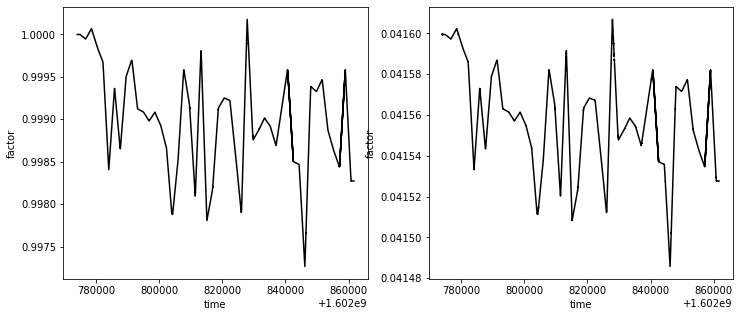

In [90]:
subplot = pltext.canvas(2)

subplot(1)
tfactor = corrfac_time(t, 0.* x, 0. * y , 0. * dt)
plt.plot(t, tfactor)
plt.xlabel('time'); plt.ylabel('factor');

subplot(2)
norma   = corrfac_norma(x, y, t)
plt.plot(t, norma);
plt.xlabel('time'); plt.ylabel('factor');


In [91]:
cf_geo = corrfac_geo(x, y)
cf_lt  = corrfac_lt (x, y, dt)
cf_nor = corrfac_norma(x, y, t)

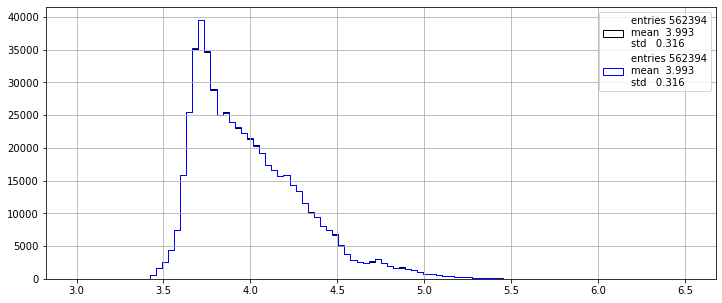

In [92]:
pltext.canvas(1)
crange = (3, 6.5)
pltext.hist( 1e6 * cf_geo * cf_lt * cf_nor, 100, range = crange);
pltext.hist( 1e6 * corrfac(x, y, dt, t), 100, range = crange);

**Conclusions**:
    
  * normal in time is a constant (41.5 keV) vs time evolution

  * time evolution follows the up/down of the maps
  
  * the 3 factors are equal to the total correction!

## Check the energy is the same in hits and event-summary. High and Low threshold

In [93]:
dfsum = esme_dfs[2]
xsel = np.isin(dfsum.event, events)
print('selected events ', np.sum(xsel))
dfsum = dfsum[xsel]

selected events  2699


In [94]:
def test_energy_sum(dfsum, dfh):
    x, y, z, dt, erec, eraw, t = get_hits(dfh)
    erec_check = eraw * corrfac(x, y, dt, t)
    dfh['Ec_check'] = erec_check
    
    range_e = (1.55, 1.76)
    ddmax = dfh.groupby('event').sum()

    pltext.canvas(1, 1)
    pltext.hist(dfsum['energy'], 100, range = range_e, label = 'event energy');
    pltext.hist(ddmax['Ec'], 100, range = range_e, label = 'hits energy sum');
    plt.xlabel('E (MeV)');
    
def test_energy_hits(dfh):

    x, y, z, dt, erec, eraw, t = get_hits(dfh)
    erec_check = eraw * corrfac(x, y, dt, t)
    dfh['Ec_check'] = erec_check
    
    range_e = (1.55, 1.76) 
    xsel    = ut.in_range(ddmax['Ec'], range_e)
    subplot = pltext.canvas(4)
   
    subplot(1)
    pltext.hist(ddmax['Ec'][xsel], 100, range = range_e, label = 'hits energy sum');
    pltext.hist(ddmax['Ec_check'][xsel], 100, range = range_e, label = 'hits energy sum (check)');
    plt.xlabel('E (MeV)')

    subplot(2)
    #print(np.sum(np.isnan(ddmax['Ec_check'])))
    de = 100 * (ddmax['Ec'].values[xsel]/ddmax['Ec_check'].values[xsel] - 1.)
    pltext.hist(de, 100, label = 'check sum energy');
    plt.xlabel(r'$\Delta$E/E (%)');    
    
    
    range_echit = (0., 0.04) 
    subplot(3)
    pltext.hist(dfh['Ec']      , 100, range = range_echit, label = 'hits energy');
    pltext.hist(dfh['Ec_check'], 100, range = range_echit, label = 'hits energy (check)');
    plt.xlabel('E (MeV)')
    
    subplot(4)
    #print(np.sum(np.isnan(ddmax['Ec_check'])))
    de = 100 * (dfh['Ec'].values/dfh['Ec_check'].values - 1.)
    pltext.hist(de, 100, label = 'check sum energy');
    plt.xlabel(r'$\Delta$E/E (%)');    



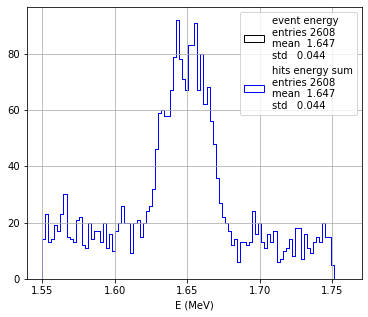

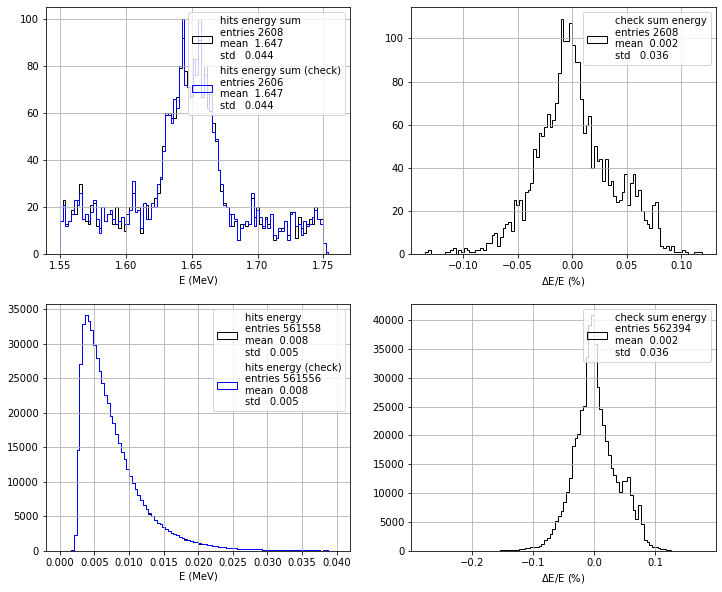

In [97]:
test_energy_sum(dfsum, dfh_HT)
test_energy_hits(dfh_HT)

**Conclusions:** With High Threshold hits
    
  * Esmeralda summary energy is the same as the HighThr hits sum energy

  * The check calibrated energy of the hits is the same to the corrected energy with a 0.04% sigma in dE/E

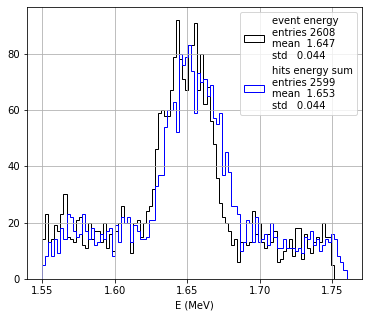

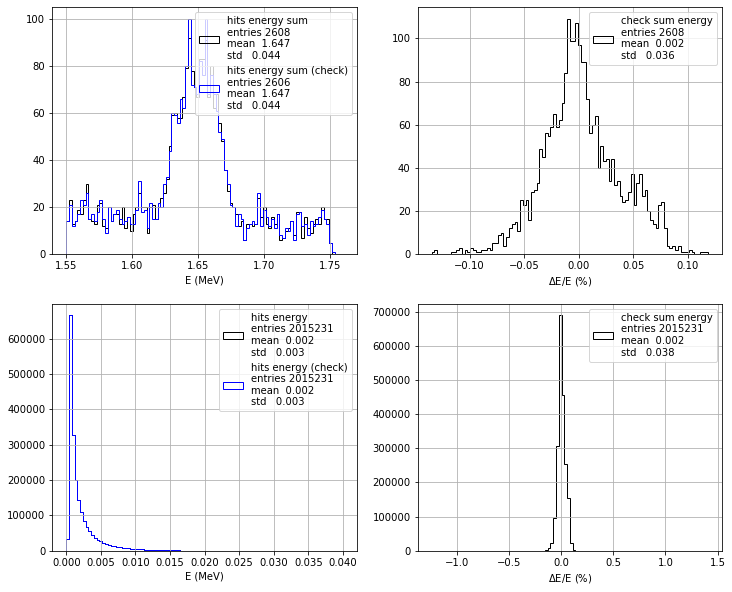

In [98]:
test_energy_sum(dfsum, dfh_LT)
test_energy_hits(dfh_LT)

**Conclusions** With low threshold hits

  * The total energy and the one from the low-threshodl hits, it is not the same. The sum of the hits energy is  0.36% more.
  
  * The std of E-sum is the same!
  
  * The calibration with low-thershold hits is the ok.

## Check nan in E 

In [105]:
def ec_nanhits(dfh):
    x, y, z, dt, erec, eraw, t = get_hits(dfh)
    r = np.sqrt(x*x + y*y)
    xnans = [np.sum(np.isnan(xi)) for xi in [x, y, z, dt, erec, eraw, t]]
    print('not a numbers (x, y, z, Ec, E, time) : ', xnans)

    xsel = np.isnan(erec) # Ec-nans
    print('nan hits :', np.sum(xsel), ', fraction : ', np.sum(xsel)/len(xsel))

    subplot = pltext.canvas(5)

    subplot(1)
    pltext.hist(z[xsel], 100, xylabels = 'z (mm)');

    subplot(2)
    pltext.hist(r[xsel], 100, xylabels = 'r (mm)');

    subplot(3)
    pltext.hist(eraw[xsel], 100, xylabels = 'E (adc)');

    subplot(4)
    pltext.hist(t[xsel], 100, xylabels = 'time');

    subplot(5)
    plt.hist2d(x[xsel], y[xsel], (50, 50), cmap = 'Greys');
    plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.grid();
    
def get_enan(dfh):
    return dfh.groupby('event').apply(lambda x : np.sum(x['E'].values[np.isnan(x['Ec'])]))

not a numbers (x, y, z, Ec, E, time) :  [0, 0, 0, 0, 40, 0, 0]
nan hits : 40 , fraction :  7.111945579392426e-05
number of events with nan hits  8 , fraction 21480.00000


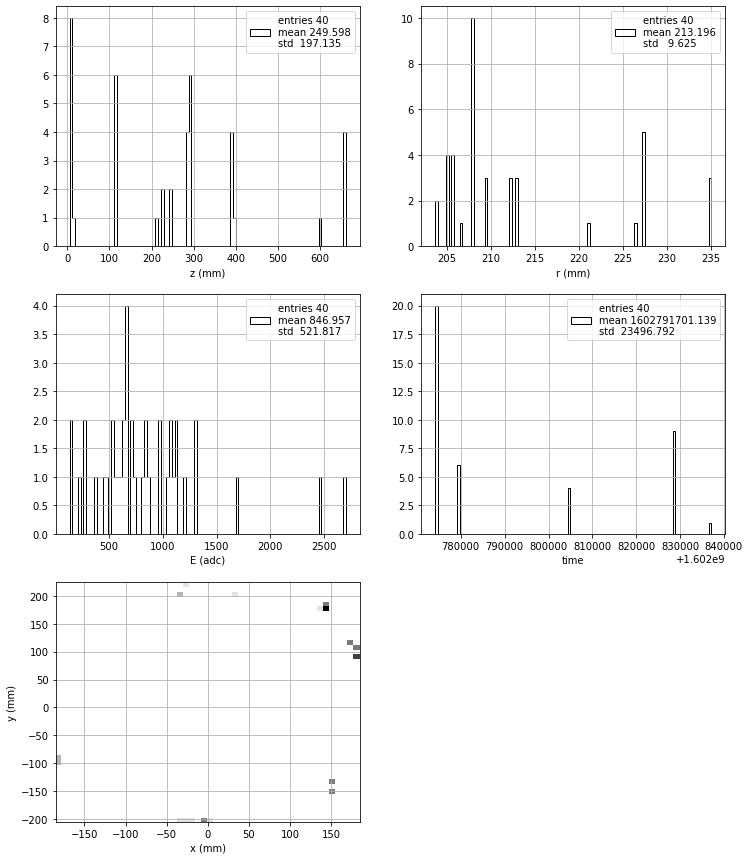

In [112]:
ec_nanhits(dfh_HT)
enan = get_enan(dfh_HT)
xsel = ut.in_range(enan, (1.e-12, 1.e12))
eff  = 1.*np.sum(xsel)/1.*len(xsel) 
print('number of events with nan hits ', np.sum(xsel), ', fraction {:6.5f}'.format(eff))

not a numbers (x, y, z, Ec, E, time) :  [0, 0, 0, 0, 2689, 0, 0]
nan hits : 2689 , fraction :  0.0013325602600697747
number of events with nan hits  1082 , fraction 0.40298


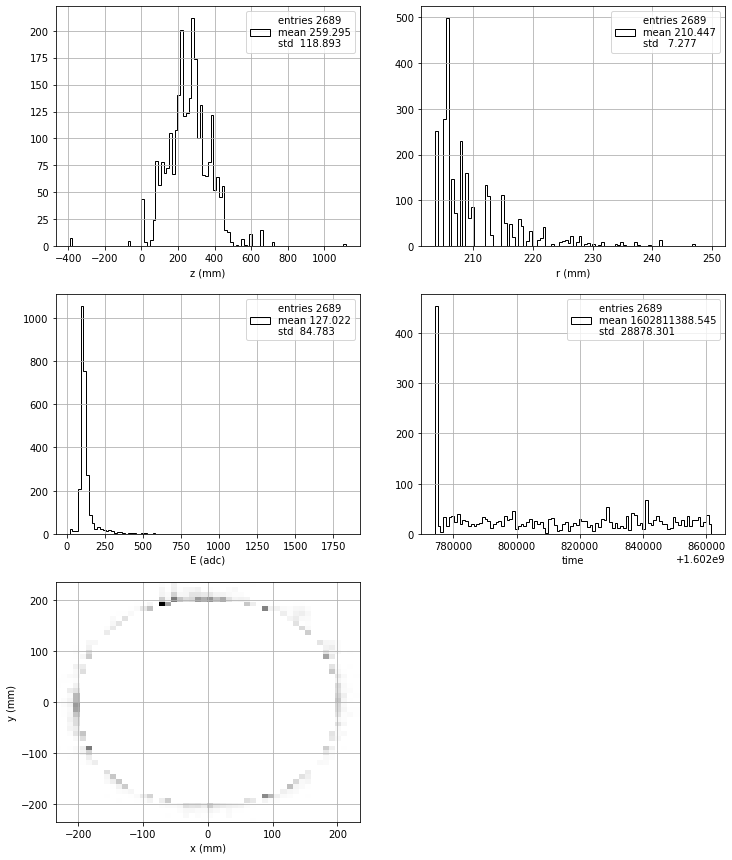

In [114]:
ec_nanhits(dfh_LT)
enan = get_enan(dfh_LT)
xsel = ut.in_range(enan, (1.e-12, 1.e12))
eff  = np.sum(xsel)/len(xsel) 
print('number of events with nan hits ', np.sum(xsel), ', fraction {:6.5f}'.format(eff))

**Conclusions:**
    
  * The hits with Ereco nan are at large radious, where the map has no correction factors, 
  
  * For the same events, with low-hits we found 40% of events with at leat one hit out of the correction region.

### Check the r_max fidutial cut

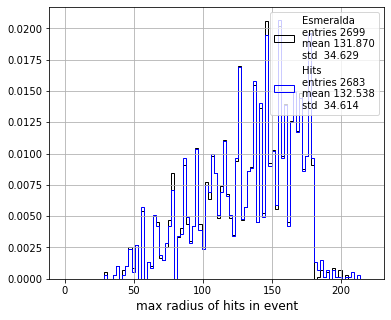

In [116]:
pltext.canvas(1, 1)
range_r = (0., 220.)
pltext.hist(dfsum.r_max, 100, range = range_r, density = True, label = 'Esmeralda');
dfh_HT['R'] = np.sqrt(dfh_HT.X**2 + dfh_HT.Y**2)
ddmax = dfh_HT.groupby('event').max()
pltext.hist(ddmax['R'], 100, range = range_r, density = True, label = 'Hits'); 
plt.xlabel('max radius of hits in event', fontsize = 12);

**Conclusions:**

  * It seems that the max/min x, y, r hit positions in the summary of esmeralda are only with 'selected' hits?

## Extended summary DF

In [122]:
ddmin = dfh.groupby('event').min()
ddmax = dfh.groupby('event').max()
ddave = dfh.groupby('event').mean()
ddsum = dfh.groupby('event').sum()

enan = dfh.groupby('event').apply(lambda x : np.sum(x['E'].values[np.isnan(x['Ec'])]))


ddc = {'X'  : ddave['X'] .values, 'Y': ddave['Y'].values, 'Z'  : ddave['Z'].values,
       'Ec' : ddsum['Ec'].values, 'E': ddsum['E'].values, 'DZ' : ddmax['Z'].values - ddmin['Z'].values,
       'Enan' : enan}

evts = ddmin.index 

ddc = pd.DataFrame(ddc, index = ddmin.index)


In [123]:
#ddc

In [129]:
ddc_ranges = {'Ec' : (1.55, 1.75), 
              'DZ' : (0.,  100.),
              'Enan.none' : (0., 1e-12),
              'Enan.ring' : (1.e-12, 1.e12)}
ddc_sels   = bes.Selections(ddc, ddc_ranges)
print(ddc_sels)

Ec : Ec [1.55, 1.75],  entries 2554, efficiency 0.95121
DZ : DZ [0.0, 100.0],  entries 2574, efficiency 0.95866
Enan.none : Enan [0.0, 1e-12],  entries 1603, efficiency 0.59702
Enan.ring : Enan [1e-12, 1000000000000.0],  entries 1082, efficiency 0.40298



overwriting  contained  selection
overwriting  non-contained  selection


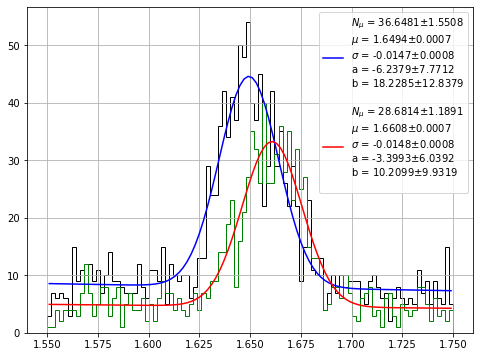

In [131]:
xsel = ddc_sels.logical_and(('Ec', 'DZ', 'Enan.none'), 'contained')
ysel = ddc_sels.logical_and(('Ec', 'DZ', 'Enan.ring'), 'non-contained')

pltext.canvas(1, 1, 6, 8)


pltext.hfit(ddc.Ec[xsel], 100, 'gausline', range = erange, formate = '6.4f');
pltext.hfit(ddc.Ec[ysel], 100, 'gausline', range = erange, formate = '6.4f');


In [132]:
235.*1.47/1649, 235*1.44/1661

(0.2094906003638569, 0.2037326911499097)

**Conclusion:**
    
  * Same resolution, but different offset!

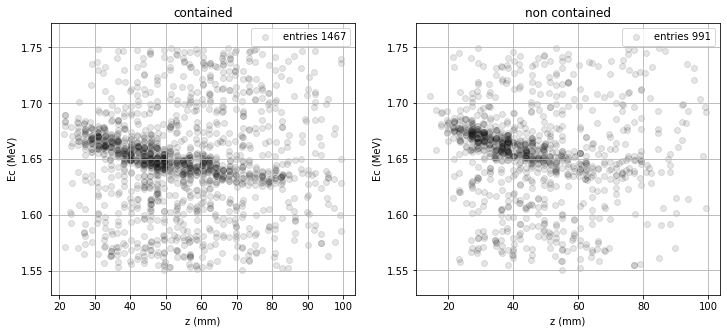

In [137]:
subplot = pltext.canvas(2)

xsel = ddc_sels['contained']
ysel = ddc_sels['non-contained']

subplot(1)
xsel = ut.in_range(ddc.Ec, erange) & ut.in_range(ddc.DZ, range_dz) & (ddc.Enan <= 1.e-6)
plt.scatter(ddc.DZ[xsel], ddc.Ec[xsel], alpha = 0.1, label = 'entries ' +str(np.sum(xsel)));
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel(label + ' (MeV)'); plt.legend(); plt.title('contained')

subplot(2)
plt.scatter(ddc.DZ[ysel], ddc.Ec[ysel], alpha = 0.1, label = 'entries ' +str(np.sum(ysel)));
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel(label + ' (MeV)'); plt.legend(); plt.title('non contained');



**Conclusions**

  * Maybe slightly different slopes, loner tracks for contained tracks

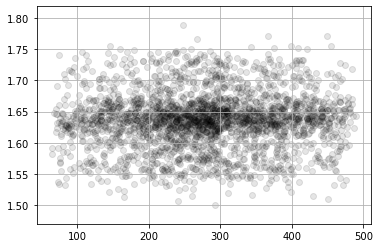

In [53]:
label = 'Ec_ave'
#zsel = (ddc.DZ < 100.) & (ddc.E > 300000.) #& (ddc[label] > 1.5) & (ddc[label] < 1.78)
zsel = (ddc.DZ < 100.) & (ddc.E > 300000.) #& (ddc[label] > 1.5) & (ddc[label] < 1.78)
plt.scatter(ddc.Z[zsel], ddc[zsel][label], alpha = 0.1); plt.grid();

**Conclusions:**

  * The $\Delta$z effect is still there